In [1]:
required_packages <- c(
  "forecast",       # ARIMAX modeling
  "dplyr",          # Data manipulation
  "tidyr",          # pivot_wider/pivot_longer
  "prophet",        # xreg forecasting
  "thief",          # h
  "TSrepr",         # Errors
  "ggplot2",
  "stringr"
)

# Install missing packages
new_packages <- required_packages[!required_packages %in% installed.packages()[,"Package"]]
if(length(new_packages)) install.packages(new_packages)

# Load all packages
invisible(lapply(required_packages, library, character.only = TRUE))

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Loading required package: rlang



In [168]:
# Nustatyk norimą seriją
store_id <- "CA_1"
dept_id <- "FOODS_1"
series_id <- paste(store_id, dept_id, sep = "_")

In [169]:
# 1. Įkeliami failai
train <- read.csv("sales_train_validation.csv")
test <- read.csv("sales_test_validation.csv")
arimax <- read.csv("submission_arimax9.csv")
ets <- read.csv("PF_ES_bu.csv")

In [170]:
# 2. Gauti tikrąsias treniravimo ir testavimo reikšmes
true_train <- train %>%
  filter(store_id == "CA_1", dept_id == "FOODS_1") %>%
  select(starts_with("d_")) %>%
  colSums()

true_test <- test %>%
  filter(store_id == "CA_1", dept_id == "FOODS_1") %>%
  select(starts_with("d_")) %>%
  colSums()

In [138]:
# 3. Gauti ARIMAX prognozes
arimax_fc <- arimax %>%
  filter(store_id == "CA_1", dept_id == "FOODS_1") %>%
  select(starts_with("F")) %>%
  as.numeric()

In [139]:
# 4. Apdoroti ETS_bu prognozes (PF_ES_bu)
ets_l12 <- ets %>%
  mutate(
    dept_id = str_extract(id, "^[^_]+_[^_]+"),
    store_id = str_extract(id, "(?<=_[A-Z]{2}_)CA_\\d|TX_\\d|WI_\\d|CA_1|TX_2|WI_3")
  ) %>%
  filter(dept_id == "FOODS_1", store_id == "CA_1")

ets_fc <- ets_l12 %>%
  select(starts_with("F")) %>%
  summarise(across(everything(), sum, na.rm = TRUE)) %>%
  as.numeric()

In [140]:
# 5. Laiko vektorius
dates <- seq(as.Date("2011-01-29"), by = "day", length.out = length(true_train) + 28)

In [189]:
# 6. Bendras duomenų rėmelis su paskutiniu mėnesiu treniravimo laikotarpyje
last_train_days <- 30
train_start <- length(true_train) - last_train_days + 1 - 28

df <- data.frame(
  date = dates[train_start:length(true_train) + 28],
  true = c(true_train[1884:length(true_train)], true_test),
  type = c(rep("Train", last_train_days), rep("True", 28)),
  arimax = c(rep(NA, last_train_days), arimax_fc),
  ets = c(rep(NA, last_train_days), ets_fc)
)

Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_line()`).”


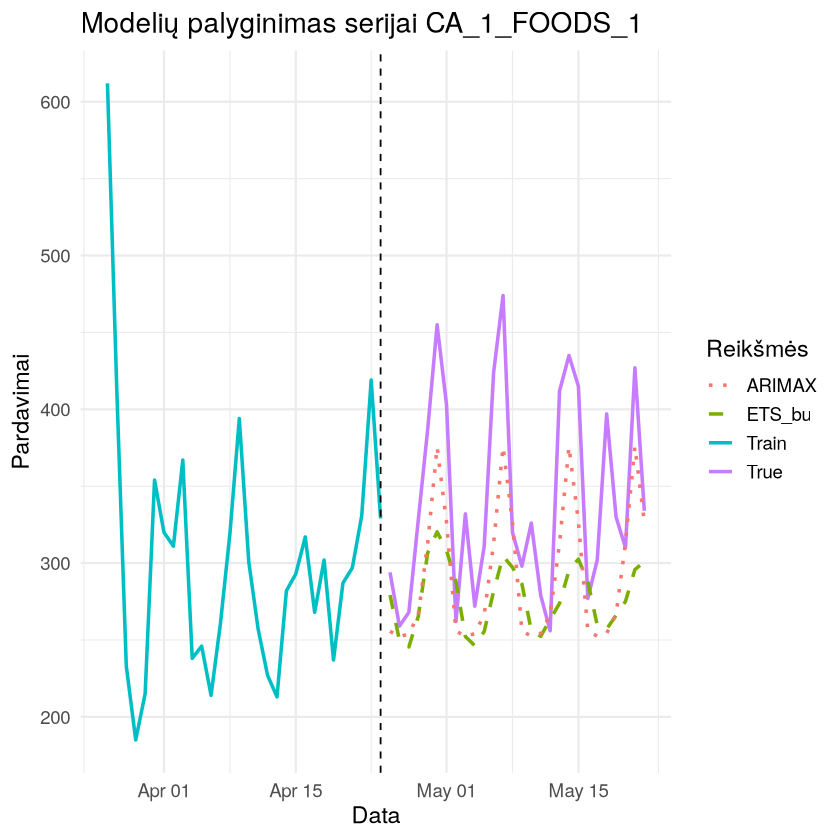

In [191]:
# 7. Grafikas
ggplot(df, aes(x = date)) +
  geom_line(aes(y = true, color = type), linewidth = 1) +
  geom_line(aes(y = arimax, color = "ARIMAX"), linewidth = 1, linetype = "dashed") +
  geom_line(aes(y = ets, color = "ETS_bu"), linewidth = 1, linetype = "dotted") +
  geom_vline(xintercept = as.Date("2016-04-24"), linetype = "dashed", color = "black") +
  labs(
    title = paste("Modelių palyginimas serijai", series_id),
    y = "Pardavimai",
    x = "Data",
    color = "Reikšmės"
  ) +
  theme_minimal(base_size = 14)

In [192]:
ggsave("modeliu_palyginimas_1.png", width = 8, height = 5, dpi = 300)

Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 30 rows containing missing values or values outside the scale range
(`geom_line()`).”
